In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import pickle

## Load dataset

In [2]:
X_train = pickle.load(open('../Data/train_enc.pkl', 'rb'))
X_test = pickle.load(open('../Data/test_enc.pkl', 'rb'))
y_train = pickle.load(open('../Data/y_train.pkl', 'rb'))
y_test = pickle.load(open('../Data/y_test.pkl', 'rb'))

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([329, 64])
torch.Size([83, 64])
(329,)
(83,)


## Exhausitive search

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the parameter grid
parameters = [{'C': [0.1, 1, 10, 100], 'kernel': ['linear']},
              {'C': [0.1, 1, 10, 100], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]

# Create a GridSearchCV object
search = GridSearchCV(SVC(probability=True), parameters, n_jobs=-1, verbose=2, cv=3)

# Fit the grid search to the data
search.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


GridSearchCV(cv=3, estimator=SVC(probability=True), n_jobs=-1,
             param_grid=[{'C': [0.1, 1, 10, 100], 'kernel': ['linear']},
                         {'C': [0.1, 1, 10, 100],
                          'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                    0.9],
                          'kernel': ['rbf']}],
             verbose=2)

In [4]:
best_params = search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'C': 0.1, 'kernel': 'linear'}


In [5]:
best_model = search.best_estimator_
best_model

SVC(C=0.1, kernel='linear', probability=True)

In [6]:
search.cv_results_

{'mean_fit_time': array([0.03105434, 0.02122625, 0.03062367, 0.02556109, 0.05839268,
        0.05313118, 0.06073038, 0.05488714, 0.04571406, 0.05235664,
        0.05385264, 0.05789121, 0.041164  , 0.05285033, 0.05569768,
        0.04728238, 0.04384367, 0.05208405, 0.04739579, 0.04473058,
        0.04573917, 0.05653628, 0.05185254, 0.04442239, 0.04865328,
        0.03930569, 0.05117528, 0.05724367, 0.04455225, 0.05675443,
        0.06664769, 0.06087176, 0.05358426, 0.0556612 , 0.06222804,
        0.04852692, 0.04873188, 0.05726854, 0.05310671, 0.045633  ]),
 'std_fit_time': array([0.00481888, 0.00502015, 0.01281557, 0.00471684, 0.00201517,
        0.00554843, 0.00627349, 0.00322461, 0.0002906 , 0.00461453,
        0.00922313, 0.00611292, 0.00336134, 0.00980076, 0.0062964 ,
        0.00419957, 0.00471432, 0.01830202, 0.00474488, 0.00497186,
        0.00771767, 0.00240376, 0.01103556, 0.00743398, 0.00153982,
        0.00344896, 0.00747726, 0.00979467, 0.00320612, 0.00900181,
        0.003

## Evaluate

In [7]:
train_acc = search.best_score_     # this is train accuracy
print("Train Accuracy:", train_acc)    

Train Accuracy: 0.9027244926327495


In [8]:
from sklearn.metrics import accuracy_score

y_pred_test = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9036144578313253


In [9]:
from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(y_test, y_pred_test)
print("AUC Score:", auc_score)

AUC Score: 0.8213619402985075


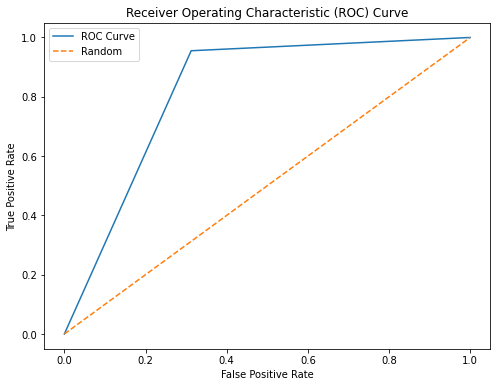

In [10]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

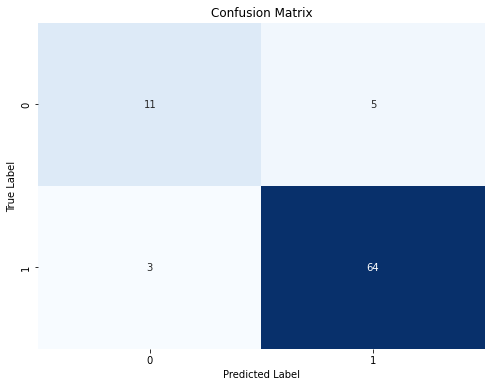

,precision,recall,f1-score,support
0,0.785714,0.687500,0.733333,16.000000
1,0.927536,0.955224,0.941176,67.000000
accuracy,0.903614,0.903614,0.903614,0.903614
macro avg,0.856625,0.821362,0.837255,83.000000
weighted avg,0.900197,0.903614,0.901110,83.000000


In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# plot confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
plt.title("Confusion Matrix")
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# print classification report as a df
cr = classification_report(y_test, y_pred_test, output_dict=True)
cr_df = pd.DataFrame(cr).transpose()
cr_df

In [12]:
svm_ae_dict = {
    'model': best_model,
    'train_acc': train_acc,
    'test_acc': test_accuracy,
    'auc_score': auc_score,
    'confusion_matrix': cm,
    'classification_report': cr_df
}

pickle.dump(svm_ae_dict, open('SVM_AE.pkl', 'wb'))